In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import zipfile
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

In [2]:
from lolopy.learners import RandomForestClassifier as loloClassifier # lolopy Random forest
from sklearn.ensemble import RandomForestClassifier # scikit learn Random Forest
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

In [3]:
cdir = os.getcwd()
print(cdir)
zip_dir = '/home/vazumah/AIML24787-Project/'
os.chdir(zip_dir)

/home/vazumah/AIML24787-Project


In [4]:
with zipfile.ZipFile('ML_Final_Project_Data.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [5]:
def nucleotide_pore_data(name='mxene'):
    
    # load adenosine dataset
    A_x = genfromtxt(f'./ML Final Project Data/a_{name}.csv',delimiter=',')
    A_x_clean = A_x[1:, 1:]
    A_y = np.zeros([A_x_clean.shape[0],1])
    A_x_p= np.zeros([A_x_clean.shape[0],1])  # 'Purine'
    
    # load cytosine dataset
    C_x = genfromtxt(f'./ML Final Project Data/c_{name}.csv',delimiter=',')
    C_x_clean = C_x[1:, 1:]
    C_y = np.ones([C_x_clean.shape[0],1])
    C_x_p= np.ones([C_x_clean.shape[0],1]) #'Pyrimidine'
    
    # load guanine dataset
    G_x = genfromtxt(f'./ML Final Project Data/g_{name}.csv',delimiter=',')
    G_x_clean = G_x[1:, 1:]
    G_y = np.zeros([G_x_clean.shape[0],1])
    G_y[:]= 2
    G_x_p= np.zeros([G_x_clean.shape[0],1]) #'Purine'
    
    #load thyiamine dataset
    T_x = genfromtxt(f'./ML Final Project Data/t_{name}.csv',delimiter=',')
    T_x_clean = T_x[1:, 1:]
    T_y = np.zeros([T_x_clean.shape[0],1])
    T_y[:] = 3
    T_x_p= np.ones([T_x_clean.shape[0],1]) #'Pyrimidine'
    
    X = np.concatenate((A_x_clean, C_x_clean,G_x_clean,T_x_clean), axis=0)
    y = np.concatenate((A_y, C_y,G_y,T_y), axis=0)
    dna_class = np.concatenate((A_x_p, C_x_p,G_x_p,T_x_p), axis=0)
    Xeng = np.concatenate((X,dna_class), axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    Xeng = scaler.fit_transform(Xeng)
    
    return X, y, dna_class, Xeng
    

### Java shenanigans  - Required for lolopy

!java -version

!conda install --yes -c cyclus java-jre
!conda install --yes -c bioconda java-jdk

In [6]:
!echo $SLURMD_NODENAME

d020


!Sys.setenv(JAVA_HOME="/home/vazumah/anaconda3/envs/NAME")

!export JAVA_HOME=/usr/java/path
!export PATH=$JAVA_HOME/bin:$PATH

# Feature Importance Analysis

In [7]:
# (b) Perform eigen decomposition and return eigen pairs in desecending order of eigen values
def eigendecomp(X):
    cov = (X.T@X)/X.shape[0]
    cov_eigs, cov_eigv=np.linalg.eig(cov)
    cov_add = np.linspace(1, X.shape[1], X.shape[1]).astype(int)
    # sort_locs = np.argsort(cov_eigs)
    # sorted_eig_vals_r = np.sort(cov_eigs, kind='heapsort')
    # sorted_eig_vals = sorted_eig_vals_r[::-1]
    # sorted_eig_vecs = cov_eigv[:, sort_locs] 
    cov_pairs=[(np.abs(cov_eigs[i]), cov_eigv[:, i], cov_add[i]) for i in range(len(cov_eigs))]
    cov_pairs.sort(key=lambda k: k[0], reverse=True)
    sorted_eig_vals = np.array([cov_pairs[i][0] for i in range(len(cov_pairs))]).reshape(-1,1)
    sorted_eig_vecs = [cov_pairs[i][1] for i in range(len(cov_pairs))]
    sorted_pairs = np.array([cov_pairs[i][2] for i in range(len(cov_pairs))]).reshape(-1,1)
    print(pd.DataFrame({"Eigenvalues": sorted_eig_vals.ravel(),"Feature Number": sorted_pairs.ravel()}))

    return (sorted_eig_vals, sorted_eig_vecs, sorted_pairs)

In [8]:
def addlabels(x,y):
    y= np.round(y,2)
    for i, x in enumerate(x):
        plt.text(x,y[i],y[i])

In [63]:
def eval(X, pore, eng=0, mode='original'):
    sorted_eig_vals, sorted_eig_vecs, sorted_pairs = eigendecomp(X)
    variance_explained = sorted_eig_vals/sorted_eig_vals.sum()
    var_weights= np.zeros([1, len(variance_explained)])

    for i, _ in enumerate(variance_explained):
        var_weights[0, i] = variance_explained[:i+1].sum()
        
    if eng!=0:
        tit = f'Dimensionality gain for Engineered {pore}'
        
    else:
        tit = f'Dimensionality gain for {pore}'
       
    tix_n = list(sorted_pairs.astype(str).ravel())   
    if mode=='original':
        if eng !=0:
            tix_labels = {'1': 'Rest Time', '2': 'Ionic Current', 
                          '3': 'Base-Class', '4': 'Bandwidth',
                          '5': 'Pass Probability'}
        else:
            tix_labels = {'1': 'Rest Time', '2': 'Ionic Current', 
                          '3': 'Bandwidth',
                          '4': 'Pass Probability'}
        tix = [tix_labels[i] for i in tix_n]
    elif mode=='expanded':
        tix = tix_n
    else:
        tix = tix_n
        
        
    plt.figure()
    plt.bar(range(1, len(variance_explained)+1), variance_explained.ravel()*100, alpha=0.5,
            align='center', label='individual explained variance',
            tick_label = tix)
    plt.step(range(1, len(variance_explained)+1), var_weights.reshape(-1,1)*100, where='mid',
            label='cumulative explained variance')
    
    plt.title(tit)
    # plt.set_xticklabels(sorted_pairs.to_list())
    plt.legend(loc='best')
    plt.xlabel('Dimensionality')
    plt.ylabel('Gain %')
    addlabels(range(1, len(variance_explained)+1),variance_explained.ravel()*100)
    # ax1 =plt.gca()
    # ax1.set_xticks(sorted_pairs)
    plt.xticks(rotation=45)
    plt.show()
    
    
    return var_weights, sorted_eig_vecs

In [10]:
pores = ['gra', 'mos', 'phos', 'mxene']
my_vars = vars()

my_vars[f'X{pores[0]}'],my_vars[f'y{pores[0]}'],my_vars[f'dna_{pores[0]}'],my_vars[f'Xeng_{pores[0]}'] = 1,1,1,1

gra
   Eigenvalues  Feature Number
0     0.334729               2
1     0.047567               1


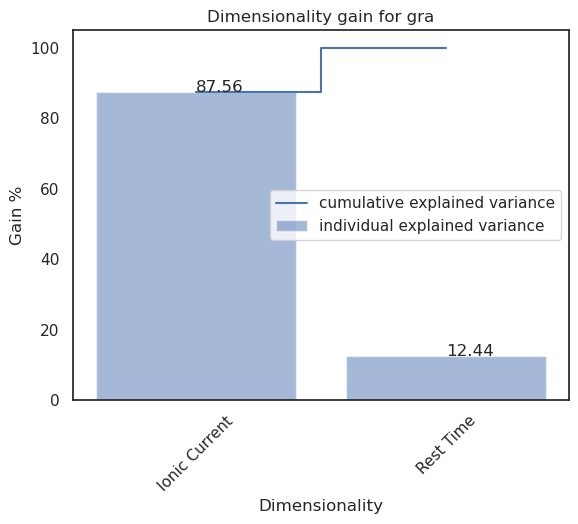

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


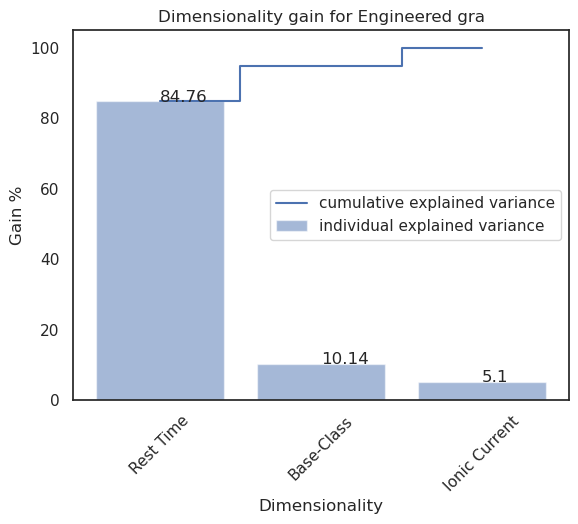

mos
   Eigenvalues  Feature Number
0     0.432829               2
1     0.027813               1


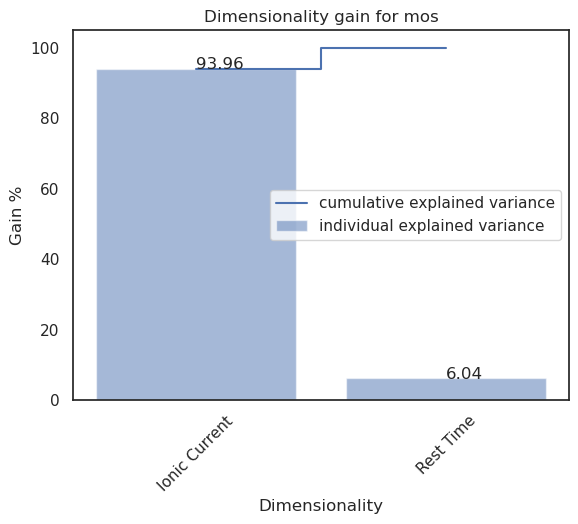

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


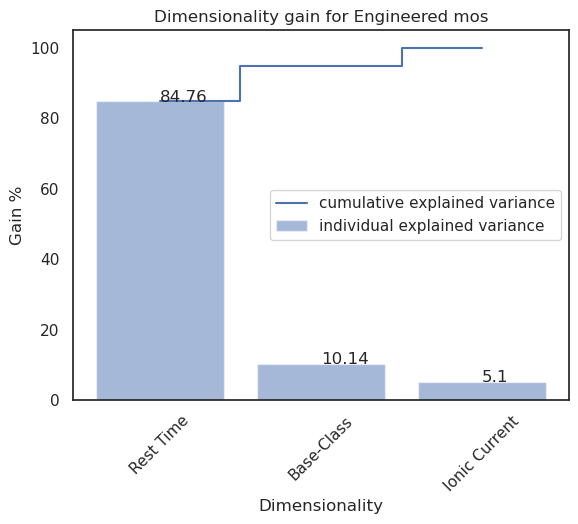

phos
   Eigenvalues  Feature Number
0     0.265445               2
1     0.036253               1


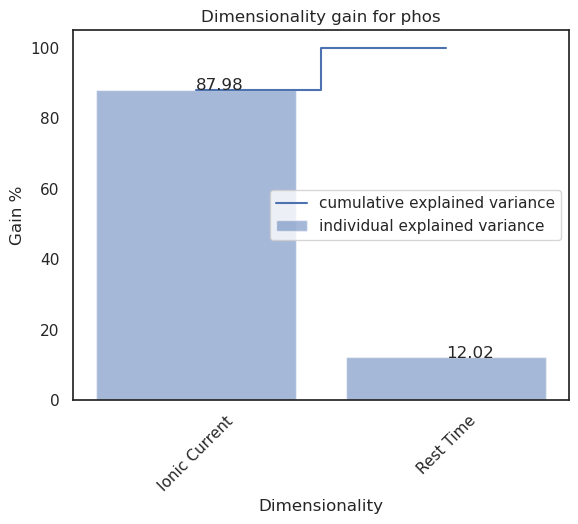

   Eigenvalues  Feature Number
0     0.788633               1
1     0.094388               3
2     0.047423               2


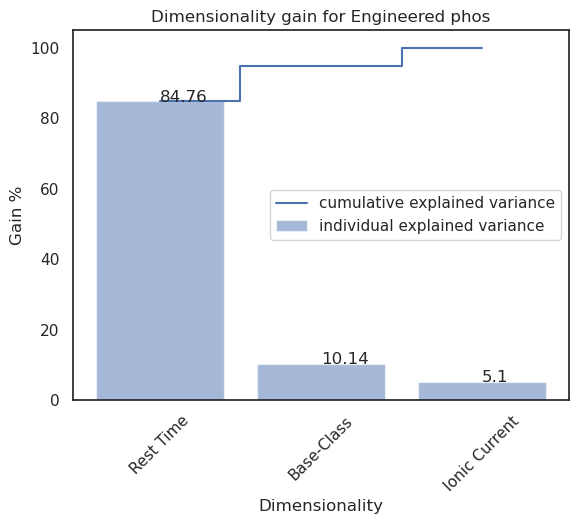

In [64]:
# Let's start for all pores
my_vars = vars()
for ind, pore in enumerate(pores):
    print(pore)
    my_vars[f'X{pore}'],my_vars[f'y{pore}'],my_vars[f'dna_{pore}'],my_vars[f'Xeng_{pore}'] = nucleotide_pore_data(name=pore)
    my_vars[f'var_weights_{pore}'],my_vars[f'sorted_eig_vecs{pore}'] =  eval(my_vars[f'X{pore}'], pore)
    my_vars[f'var_weights_{pore}_e'],my_vars[f'sorted_eig_vecs{pore}_e'] =  eval(my_vars[f'Xeng_{pores[0]}'], pore, 1)

# Nucleotide Raw Data Analysis

## Training Functions

In [12]:
def trainers(X,y):
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size =  0.3, random_state=300)
    
    decTree = tree.DecisionTreeClassifier()
    decTree = decTree.fit(X_train, y_train)
    decTree_res_pred = decTree.predict(X_test)
    decTree_score = accuracy_score(y_test, decTree_res_pred)
        
    sRanFor = RandomForestClassifier(criterion='entropy')
    sRanFor = sRanFor.fit(X_train, y_train.flatten())
    sRanFor_res_pred = sRanFor.predict(X_test)
    sRanFor_score = accuracy_score(y_test, sRanFor_res_pred)
        
    lRanFor = loloClassifier()
    lRanFor = lRanFor.fit(X_train, y_train.flatten())
    lRanFor_res_pred = lRanFor.predict(X_test)
    lRanFor_score = accuracy_score(y_test, lRanFor_res_pred)
        
    svm_model_l = svm.SVC(kernel='linear')
    svm_model_l= svm_model_l.fit(X_train, y_train.flatten())
    svm_model_l_res_pred = svm_model_l.predict(X_test)
    svm_model_l_score = accuracy_score(y_test, svm_model_l_res_pred)
        
    svm_model_r = svm.SVC()
    svm_model_r= svm_model_r.fit(X_train, y_train.flatten())
    svm_model_r_res_pred = svm_model_r.predict(X_test)
    svm_model_r_score = accuracy_score(y_test, svm_model_r_res_pred)
        
    svm_model_p = svm.SVC(kernel='poly')
    svm_model_p= svm_model_p.fit(X_train, y_train.flatten())
    svm_model_p_res_pred = svm_model_p.predict(X_test)
    svm_model_p_score = accuracy_score(y_test, svm_model_p_res_pred)
        
    svm_model_s = svm.SVC(kernel='sigmoid')
    svm_model_s= svm_model_s.fit(X_train, y_train.flatten())
    svm_model_s_res_pred = svm_model_s.predict(X_test)
    svm_model_s_score = accuracy_score(y_test, svm_model_s_res_pred)
        
    totals = [decTree_score, sRanFor_score,lRanFor_score,
              svm_model_l_score,svm_model_r_score,svm_model_s_score,svm_model_p_score]
        
#     acc_mat= np.array(totals).ravel()
    pred = [ decTree_res_pred,sRanFor_res_pred, lRanFor_res_pred,svm_model_l_res_pred,
            svm_model_r_res_pred,svm_model_p_res_pred, svm_model_s_res_pred]
        
    return totals, pred, y_test

In [13]:
def training_and_plots(X,y, mode='regular', name='mxene', analysis='default', degree=None):
    """This function performs training and plots
    
    """
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # X = scaler.fit_transform(X)
    its = 1
    if analysis=='polyset':
        trans = PolynomialFeatures(degree=degree)
        X = trans.fit_transform(X)
    elif analysis=='polysearch':
        its = degree
    
    acc_mat= np.zeros([7, its], dtype=float)
        
    
    groups = ['Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest',
              'SVM-linear', 'SVM-RBF', 'SVM-sig','SVM-poly3']
            # totals = [decTree_score, sRanFor_score,lRanFor_score]
    
    
    for ii in range(its):
        if analysis == 'polysearch':
            n= int(ii+1)
            trans = PolynomialFeatures(degree=n)
            data = trans.fit_transform(X)
            X = data
            # if ii<3:
            #     trans = PolynomialFeatures(degree=ii+1)
            #     X = trans.fit_transform(X)
            # else:
            #     trans = PolynomialFeatures(degree=ii+1, interaction_only=True)
            #     X = trans.fit_transform(X)
        
        totals, pred, y_test = trainers(X,y)
        decTree_res_pred,sRanFor_res_pred, lRanFor_res_pred,svm_model_l_res_pred,svm_model_r_res_pred,svm_model_p_res_pred, svm_model_s_res_pred = pred
        # (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size =  0.3, random_state=300)
        
        # decTree = tree.DecisionTreeClassifier()
        # decTree = decTree.fit(X_train, y_train)
        # decTree_res_pred = decTree.predict(X_test)
        # decTree_score = accuracy_score(y_test, decTree_res_pred)
        
        # sRanFor = RandomForestClassifier(criterion='entropy')
        # sRanFor = sRanFor.fit(X_train, y_train.flatten())
        # sRanFor_res_pred = sRanFor.predict(X_test)
        # sRanFor_score = accuracy_score(y_test, sRanFor_res_pred)
        
        # lRanFor = loloClassifier()
        # lRanFor = lRanFor.fit(X_train, y_train.flatten())
        # lRanFor_res_pred = lRanFor.predict(X_test)
        # lRanFor_score = accuracy_score(y_test, lRanFor_res_pred)
        
        # svm_model_l = svm.SVC(kernel='linear')
        # svm_model_l= svm_model_l.fit(X_train, y_train.flatten())
        # svm_model_l_res_pred = svm_model_l.predict(X_test)
        # svm_model_l_score = accuracy_score(y_test, svm_model_l_res_pred)
        
        # svm_model_r = svm.SVC()
        # svm_model_r= svm_model_r.fit(X_train, y_train.flatten())
        # svm_model_r_res_pred = svm_model_r.predict(X_test)
        # svm_model_r_score = accuracy_score(y_test, svm_model_r_res_pred)
        
        # svm_model_p = svm.SVC(kernel='poly')
        # svm_model_p= svm_model_p.fit(X_train, y_train.flatten())
        # svm_model_p_res_pred = svm_model_p.predict(X_test)
        # svm_model_p_score = accuracy_score(y_test, svm_model_p_res_pred)
        
        # svm_model_s = svm.SVC(kernel='sigmoid')
        # svm_model_s= svm_model_s.fit(X_train, y_train.flatten())
        # svm_model_s_res_pred = svm_model_s.predict(X_test)
        # svm_model_s_score = accuracy_score(y_test, svm_model_s_res_pred)
        
        # totals = [decTree_score, sRanFor_score,lRanFor_score,
        #           svm_model_l_score,svm_model_r_score,svm_model_s_score,svm_model_p_score]
        
        # acc_mat[:, ii] = np.array(totals).ravel()
    
    
    
    if analysis!='polysearch':
        # Dec tree score per base
        if mode=='binary':
            Purine_score_dec = accuracy_score(y_test[y_test==0], decTree_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_dec = accuracy_score(y_test[y_test==1], decTree_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_sF = accuracy_score(y_test[y_test==0], sRanFor_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_sF = accuracy_score(y_test[y_test==1], sRanFor_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_lF = accuracy_score(y_test[y_test==0], lRanFor_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_lF = accuracy_score(y_test[y_test==1], lRanFor_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_l = accuracy_score(y_test[y_test==0], svm_model_l_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_l = accuracy_score(y_test[y_test==1], svm_model_l_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_r = accuracy_score(y_test[y_test==0], svm_model_r_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_r = accuracy_score(y_test[y_test==1], svm_model_r_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_p = accuracy_score(y_test[y_test==0], svm_model_p_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_p = accuracy_score(y_test[y_test==1], svm_model_p_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_s = accuracy_score(y_test[y_test==0], svm_model_s_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_s = accuracy_score(y_test[y_test==1], svm_model_s_res_pred.reshape(-1,1)[y_test==1])
            
            
            # groups = ['Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest']
            # groups = ['Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest',
            #         'SVM-linear', 'SVM-RBF', 'SVM-sig','SVM-poly3']
            
            # totals_p = [decTree_score, sRanFor_score,lRanFor_score]
            # totals_p = [decTree_score, sRanFor_score,lRanFor_score, 
            #             svm_model_l_score, svm_model_r_score,svm_model_s_score,svm_model_p_score]
            totals_p = totals
            
            # Purine_scores = [Purine_score_dec,Purine_score_sF,Purine_score_lF]
            # Pyrimidine_scores = [Pyrimidine_score_dec,Pyrimidine_score_sF,Pyrimidine_score_lF]

            Purine_scores = [Purine_score_dec,Purine_score_sF,Purine_score_lF, 
                            Purine_score_svm_l, Purine_score_svm_r, Purine_score_svm_s,Purine_score_svm_p]
            Pyrimidine_scores = [Pyrimidine_score_dec,Pyrimidine_score_sF,Pyrimidine_score_lF,
                                Pyrimidine_score_svm_l, Pyrimidine_score_svm_r, Pyrimidine_score_svm_s,Pyrimidine_score_svm_p]

            group_dic = {'Models':[*groups[:], *groups[:], *groups[:]],
                        'Scores':[*totals_p[:], *Purine_scores[:], *Pyrimidine_scores[:]],
                        'Classes': ['Totals','Totals','Totals','Totals','Totals','Totals','Totals',
                                    'Purine','Purine','Purine','Purine','Purine','Purine','Purine',
                                    'Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine']}

            group_list = [dict(zip(group_dic,t)) for t in zip(*group_dic.values())]

        else:
            A_score_dec = accuracy_score(y_test[y_test==0], decTree_res_pred.reshape(-1,1)[y_test==0])
            C_score_dec = accuracy_score(y_test[y_test==1], decTree_res_pred.reshape(-1,1)[y_test==1])
            G_score_dec = accuracy_score(y_test[y_test==2], decTree_res_pred.reshape(-1,1)[y_test==2])
            T_score_dec = accuracy_score(y_test[y_test==3], decTree_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_sF = accuracy_score(y_test[y_test==0], sRanFor_res_pred.reshape(-1,1)[y_test==0])
            C_score_sF = accuracy_score(y_test[y_test==1], sRanFor_res_pred.reshape(-1,1)[y_test==1])
            G_score_sF = accuracy_score(y_test[y_test==2], sRanFor_res_pred.reshape(-1,1)[y_test==2])
            T_score_sF = accuracy_score(y_test[y_test==3], sRanFor_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_lF = accuracy_score(y_test[y_test==0], lRanFor_res_pred.reshape(-1,1)[y_test==0])
            C_score_lF = accuracy_score(y_test[y_test==1], lRanFor_res_pred.reshape(-1,1)[y_test==1])
            G_score_lF = accuracy_score(y_test[y_test==2], lRanFor_res_pred.reshape(-1,1)[y_test==2])
            T_score_lF = accuracy_score(y_test[y_test==3], lRanFor_res_pred.reshape(-1,1)[y_test==3])

            A_score_svm_l = accuracy_score(y_test[y_test==0], svm_model_l_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_l = accuracy_score(y_test[y_test==1], svm_model_l_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_l = accuracy_score(y_test[y_test==2], svm_model_l_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_l = accuracy_score(y_test[y_test==3], svm_model_l_res_pred.reshape(-1,1)[y_test==3])

            A_score_svm_r = accuracy_score(y_test[y_test==0], svm_model_r_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_r = accuracy_score(y_test[y_test==1], svm_model_r_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_r = accuracy_score(y_test[y_test==2], svm_model_r_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_r = accuracy_score(y_test[y_test==3], svm_model_r_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_svm_s = accuracy_score(y_test[y_test==0], svm_model_s_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_s = accuracy_score(y_test[y_test==1], svm_model_s_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_s = accuracy_score(y_test[y_test==2], svm_model_s_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_s = accuracy_score(y_test[y_test==3], svm_model_s_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_svm_p = accuracy_score(y_test[y_test==0], svm_model_p_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_p = accuracy_score(y_test[y_test==1], svm_model_p_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_p = accuracy_score(y_test[y_test==2], svm_model_p_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_p = accuracy_score(y_test[y_test==3], svm_model_p_res_pred.reshape(-1,1)[y_test==3])



            # groups = ['Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest']
            # groups = ['Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest',
            #         'SVM-linear', 'SVM-RBF', 'SVM-sig','SVM-poly3']
            # # totals = [decTree_score, sRanFor_score,lRanFor_score]
            # totals = [decTree_score, sRanFor_score,lRanFor_score,
            #         svm_model_l_score,svm_model_r_score,svm_model_s_score,svm_model_p_score]
            
            # A_scores = [A_score_dec,A_score_sF,A_score_lF,]
            # C_scores = [C_score_dec,C_score_sF,C_score_lF]
            # G_scores = [G_score_dec,G_score_sF,G_score_lF]
            # T_scores = [T_score_dec,T_score_sF,T_score_lF]
            
            A_scores = [A_score_dec,A_score_sF,A_score_lF,
                        A_score_svm_l,A_score_svm_r,A_score_svm_s,A_score_svm_p]
            C_scores = [C_score_dec,C_score_sF,C_score_lF,
                        C_score_svm_l,C_score_svm_r,C_score_svm_s,C_score_svm_p]
            G_scores = [G_score_dec,G_score_sF,G_score_lF,
                        G_score_svm_l,G_score_svm_r,G_score_svm_s,G_score_svm_p]
            T_scores = [T_score_dec,T_score_sF,T_score_lF,
                        T_score_svm_l,T_score_svm_r,T_score_svm_s,T_score_svm_p]

            group_dic = {'Models':[*groups[:], *groups[:], *groups[:], *groups[:], *groups[:]],
                        'Scores':[*totals[:], *A_scores[:], *C_scores[:], *G_scores[:], *T_scores[:]],
                        'Classes': ['Totals','Totals','Totals','Totals','Totals','Totals','Totals',
                                    'A','A','A','A','A','A','A',
                                    'C','C','C','C','C','C','C',
                                    'G','G','G','G','G','G','G',
                                    'T','T','T','T','T','T','T']}

            group_list = [dict(zip(group_dic,t)) for t in zip(*group_dic.values())]
        
        
        group_df = pd.DataFrame(group_list)
        # pore_type = np.chararray([group_df.shape[0],1])
        # pore_type[:] = name
        pore_type = np.repeat(name, group_df.shape[0])
        group_df['pore_type'] = pore_type.tolist()
                
        return group_df
    else:
        return acc_mat

## Mxene Plots

In [14]:
Xxene, yxene, dna_xene, Xxeng = nucleotide_pore_data(name='mxene')

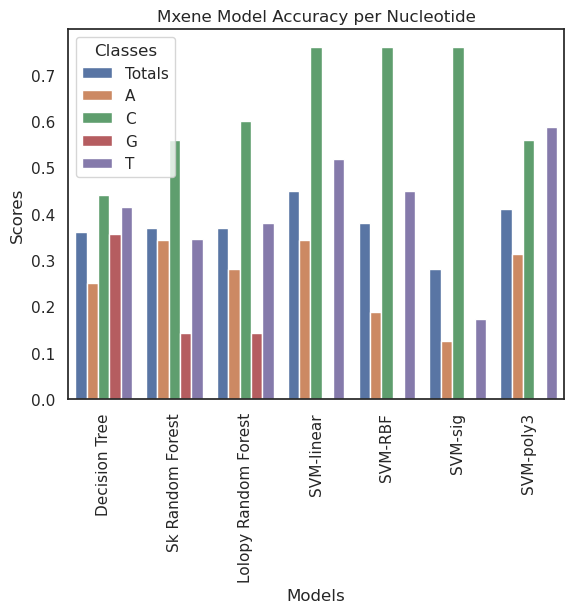

In [15]:
# Regular training
mxene_df = training_and_plots(Xxene,yxene)
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=mxene_df).set(title='Mxene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

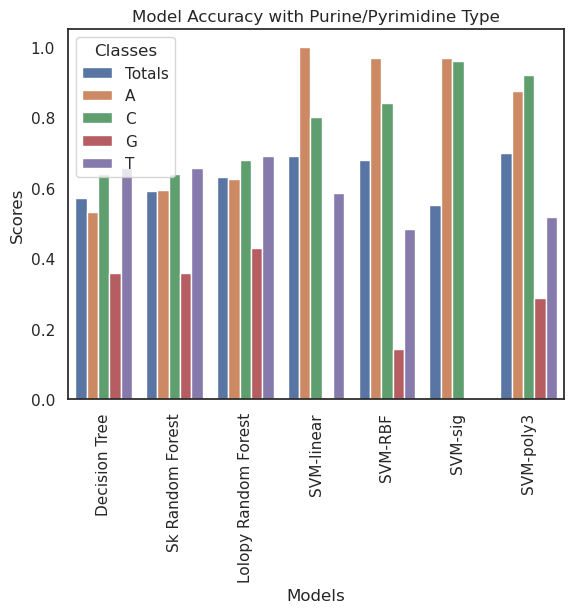

In [16]:
# training with purines and pyrimidines engineering
mxene_df_e = training_and_plots(Xxeng, yxene)
# group_df = pd.DataFrame.from_dict(group_dic)
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=mxene_df_e).set(title='Model Accuracy with Purine/Pyrimidine Type') 
plt.xticks(rotation=90)
plt.show()

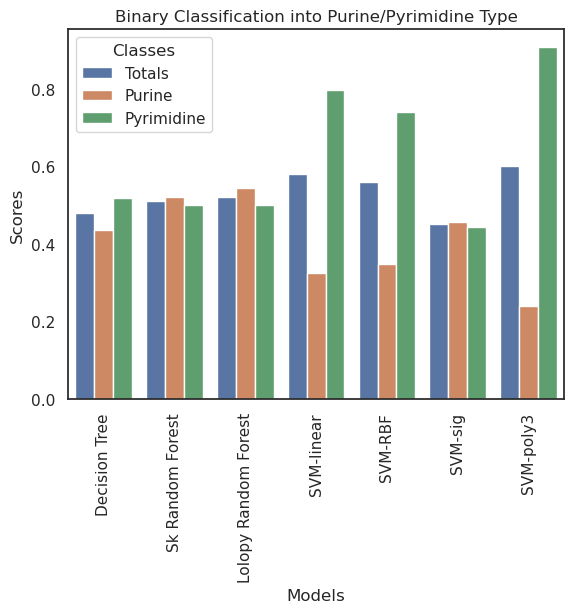

In [17]:
#classifying only purines and pyrimidines
mxene_df_p = training_and_plots(Xxene,dna_xene, mode='binary')
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=mxene_df_p).set(title='Binary Classification into Purine/Pyrimidine Type')
plt.xticks(rotation=90)
plt.show()

## Initializing other Pores

In [18]:
pores = ['gra', 'mos', 'phos']

In [19]:
my_vars = vars()

my_vars[f'X{pores[0]}'],my_vars[f'y{pores[0]}'],my_vars[f'dna_{pores[0]}'],my_vars[f'Xeng_{pores[0]}'] = 1,1,1,1

In [20]:
# Let's start for all pores
my_vars = vars()
for ind, pore in enumerate(pores):
    print(pore)
    my_vars[f'X{pore}'],my_vars[f'y{pore}'],my_vars[f'dna_{pore}'],my_vars[f'Xeng_{pore}'] = nucleotide_pore_data(name=pore)
    my_vars[f'{pore}_df'] = training_and_plots(my_vars[f'X{pore}'],my_vars[f'y{pore}'], name=pore)
    my_vars[f'{pore}_df_e'] = training_and_plots(my_vars[f'Xeng_{pore}'], my_vars[f'y{pore}'], name=pore)
    my_vars[f'{pore}_df_p'] = training_and_plots(my_vars[f'X{pore}'],my_vars[f'dna_{pore}'], mode='binary', name=pore)

gra
mos
phos


## Graphite Studies

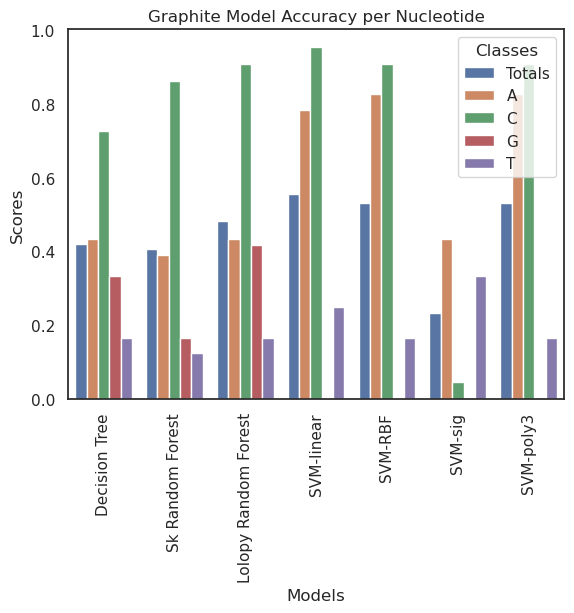

In [21]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=gra_df).set(title='Graphite Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

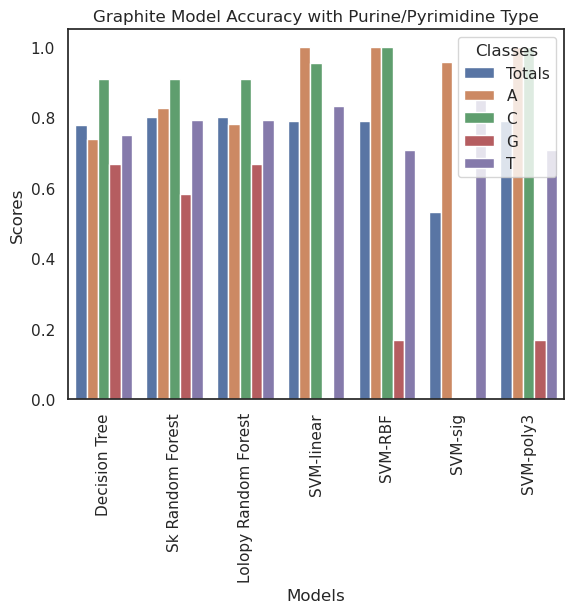

In [22]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=gra_df_e).set(title='Graphite Model Accuracy with Purine/Pyrimidine Type') 
plt.xticks(rotation=90)
plt.show()

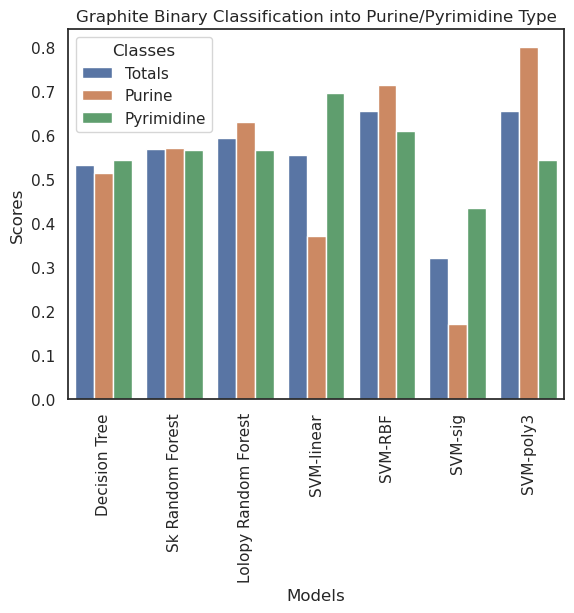

In [23]:
#classifying only purines and pyrimidines
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=gra_df_p).set(title='Graphite Binary Classification into Purine/Pyrimidine Type')
plt.xticks(rotation=90)
plt.show()

## MOS Studies

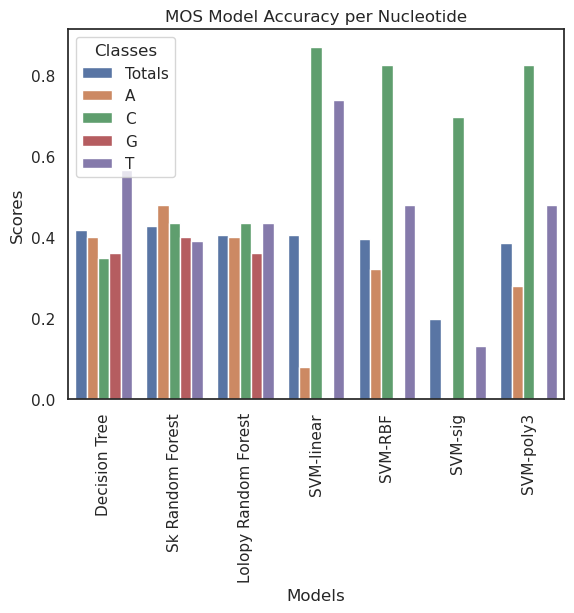

In [24]:

sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=mos_df).set(title='MOS Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

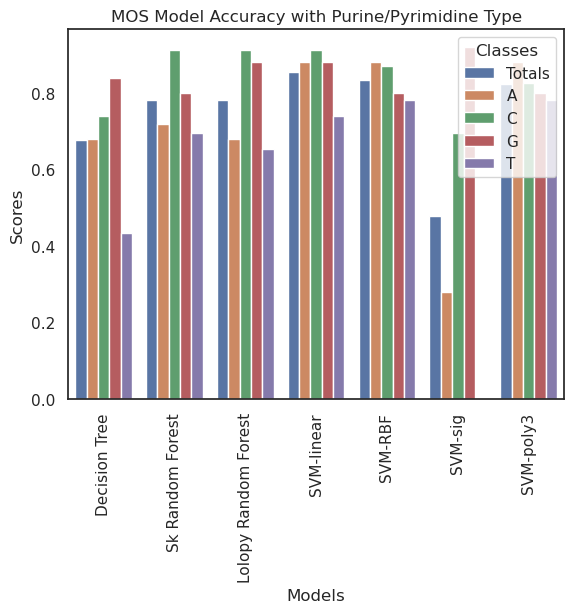

In [25]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=mos_df_e).set(title='MOS Model Accuracy with Purine/Pyrimidine Type') 
plt.xticks(rotation=90)
plt.show()

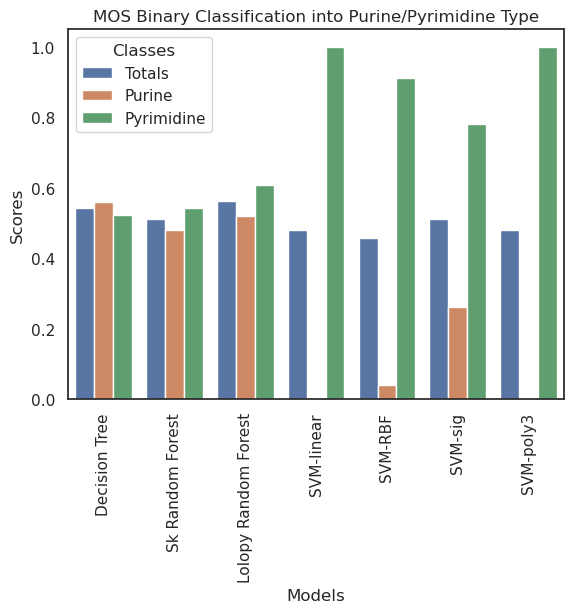

In [26]:
#classifying only purines and pyrimidines
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=mos_df_p).set(title='MOS Binary Classification into Purine/Pyrimidine Type')
plt.xticks(rotation=90)
plt.show()

## Phospherene studies

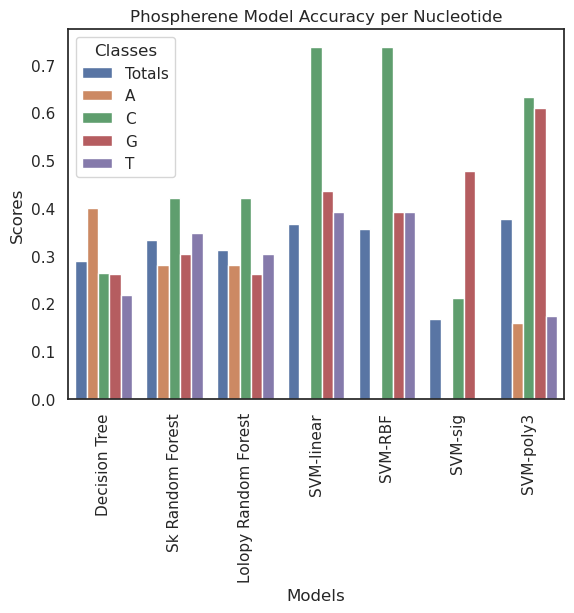

In [27]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_df).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

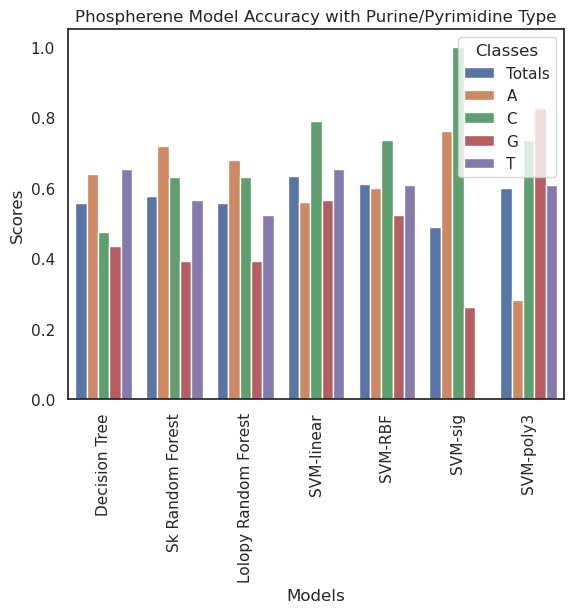

In [28]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_df_e).set(title='Phospherene Model Accuracy with Purine/Pyrimidine Type') 
#classifying only purines and pyrimidines
plt.xticks(rotation=90)
plt.show()

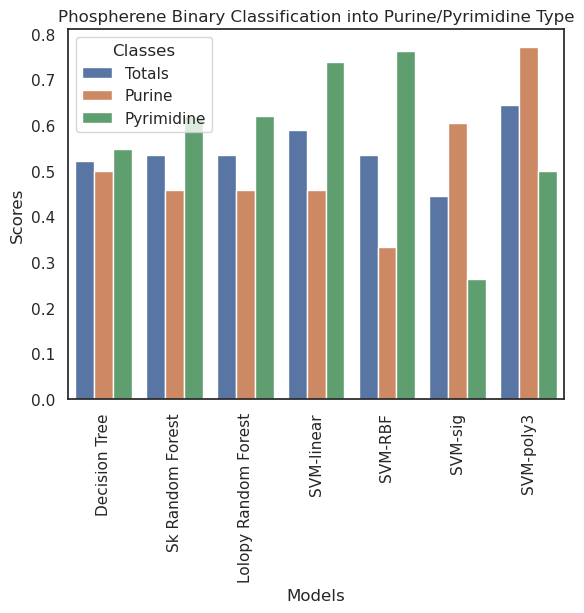

In [29]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_df_p).set(title='Phospherene Binary Classification into Purine/Pyrimidine Type')
plt.xticks(rotation=90)
plt.show()

# Comparing entire Dataset

In [30]:
# all_data_df = mxene_df.append([gra_df, mos_df, phos_df], ignore_index=True)
all_data_df = pd.concat([mxene_df, gra_df, mos_df, phos_df], axis=0,ignore_index=True)
all_data_df_e = pd.concat([mxene_df_e, gra_df_e, mos_df_e, phos_df_e], axis=0,ignore_index=True)
# all_data_df_p = pd.concat([mxene_df_p, gra_df_p, mos_df_p, phos_df_p], axis=0,ignore_index=True)

## Across Totals

<class 'pandas.core.frame.DataFrame'>


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

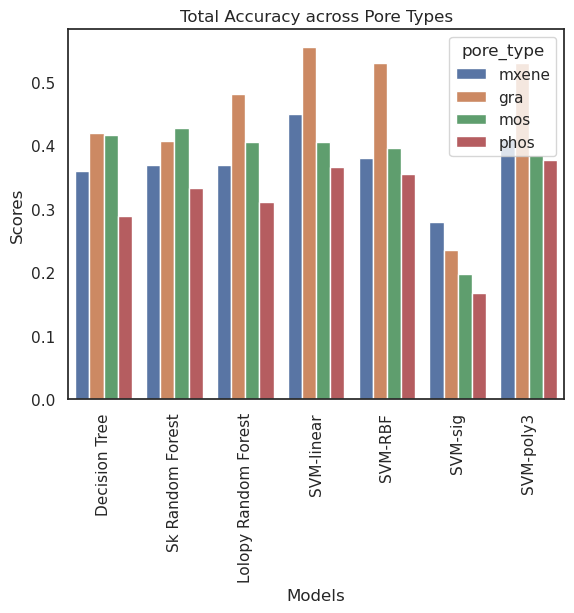

In [31]:
totals_pos =all_data_df.index[all_data_df['Classes']=='Totals'].tolist()
totals_df = all_data_df.iloc[totals_pos,:]
print(type(totals_df))
# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=totals_df).set(title='Total Accuracy across Pore Types')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

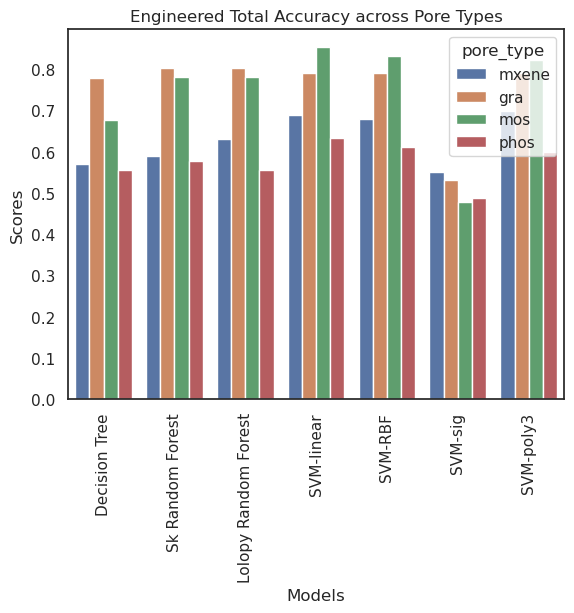

In [32]:
totals_pos_e =all_data_df_e.index[all_data_df_e['Classes']=='Totals'].tolist()
totals_df_e = all_data_df_e.iloc[totals_pos_e,:]
# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=totals_df_e).set(title='Engineered Total Accuracy across Pore Types')
plt.xticks(rotation=90)

## Across A

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

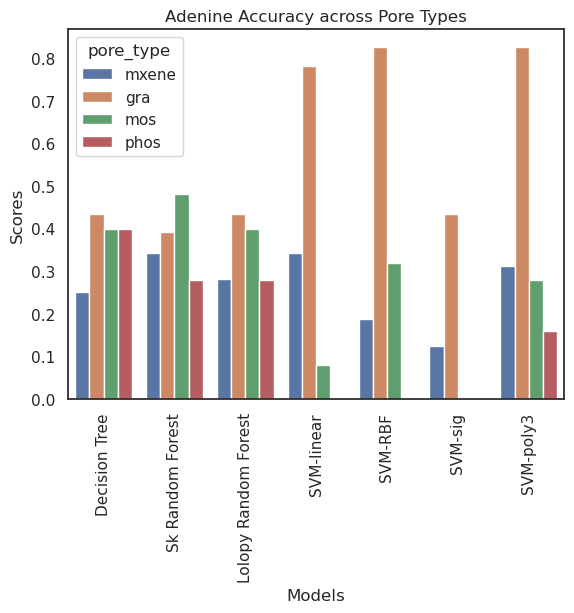

In [33]:
A_pos =all_data_df.index[all_data_df['Classes']=='A'].tolist()
A_df = all_data_df.iloc[A_pos,:]

# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=A_df).set(title='Adenine Accuracy across Pore Types')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

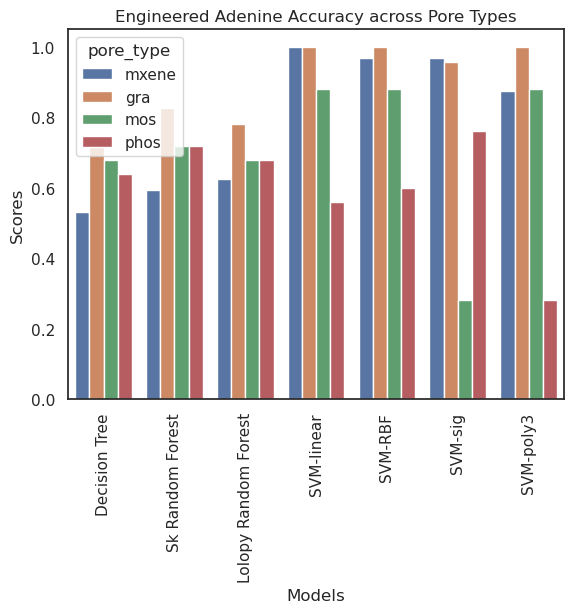

In [34]:
A_pos_e =all_data_df_e.index[all_data_df_e['Classes']=='A'].tolist()
A_df_e = all_data_df_e.iloc[A_pos_e,:]
# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=A_df_e).set(title='Engineered Adenine Accuracy across Pore Types')
plt.xticks(rotation=90)

## Across C

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

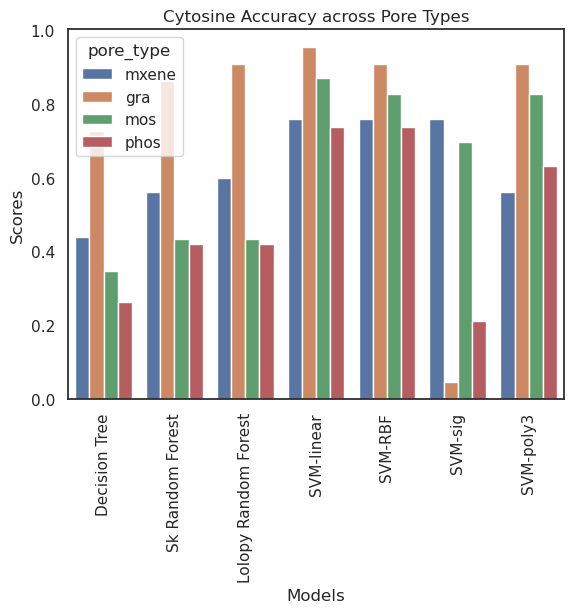

In [35]:
C_pos =all_data_df.index[all_data_df['Classes']=='C'].tolist()
C_df = all_data_df.iloc[C_pos,:]

# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=C_df).set(title='Cytosine Accuracy across Pore Types')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

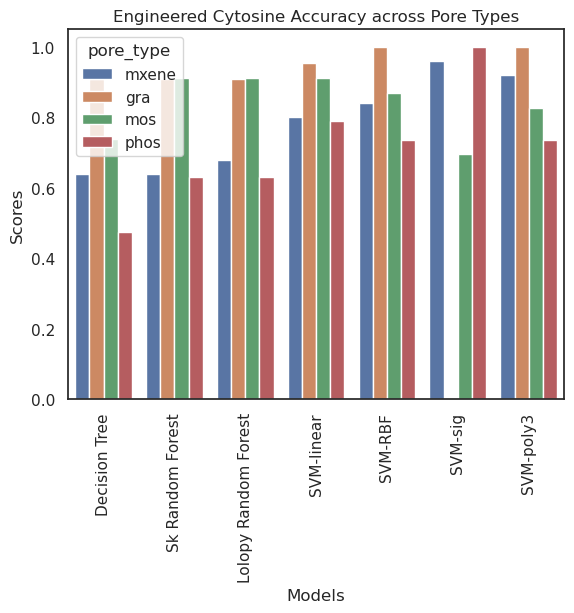

In [36]:
C_pos_e =all_data_df_e.index[all_data_df_e['Classes']=='C'].tolist()
C_df_e = all_data_df_e.iloc[C_pos_e,:]
# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=C_df_e).set(title='Engineered Cytosine Accuracy across Pore Types')
plt.xticks(rotation=90)

## Across G

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

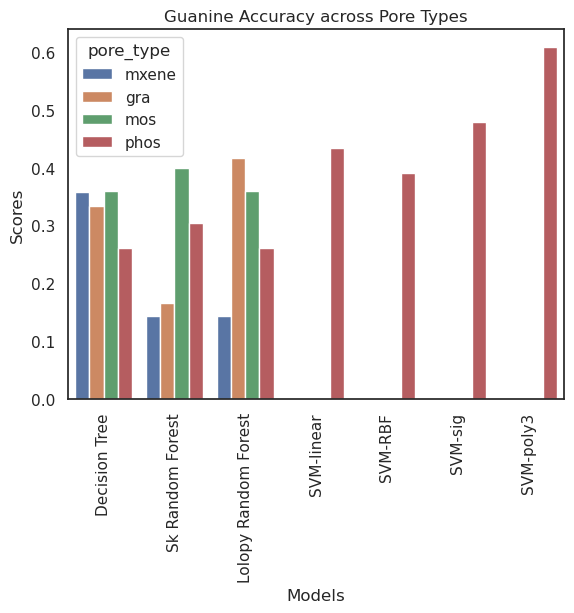

In [37]:
G_pos =all_data_df.index[all_data_df['Classes']=='G'].tolist()
G_df = all_data_df.iloc[G_pos,:]

# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=G_df).set(title='Guanine Accuracy across Pore Types')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

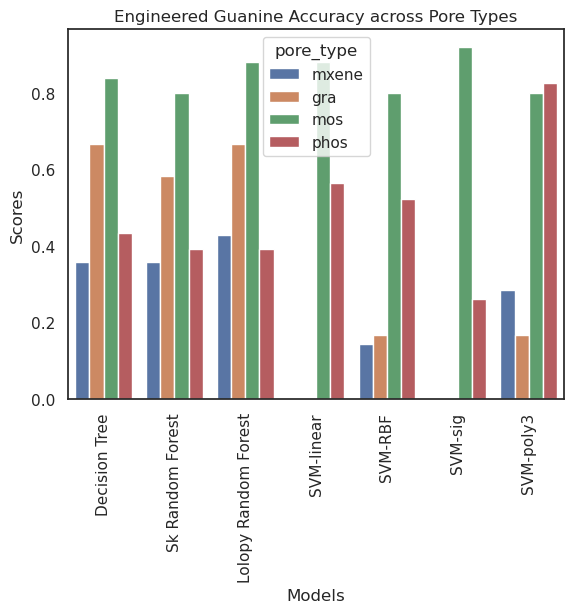

In [38]:
G_pos_e =all_data_df_e.index[all_data_df_e['Classes']=='G'].tolist()
G_df_e = all_data_df_e.iloc[G_pos_e,:]
# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=G_df_e).set(title='Engineered Guanine Accuracy across Pore Types')
plt.xticks(rotation=90)

## Across T

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

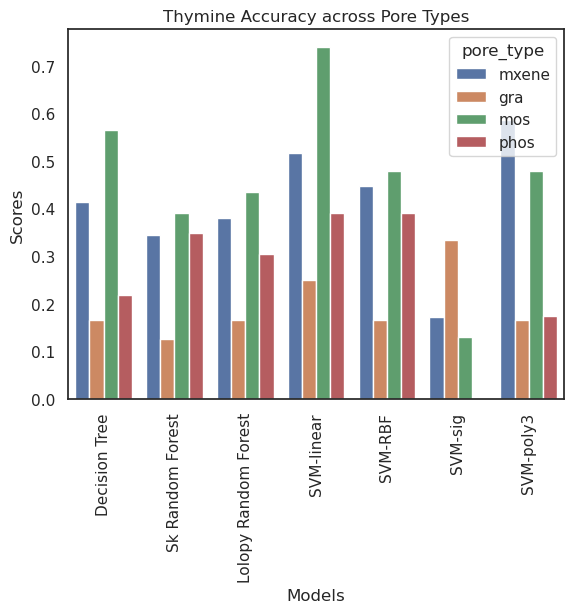

In [39]:
T_pos =all_data_df.index[all_data_df['Classes']=='T'].tolist()
T_df = all_data_df.iloc[T_pos,:]

# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=T_df).set(title='Thymine Accuracy across Pore Types')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Sk Random Forest'),
  Text(2, 0, 'Lolopy Random Forest'),
  Text(3, 0, 'SVM-linear'),
  Text(4, 0, 'SVM-RBF'),
  Text(5, 0, 'SVM-sig'),
  Text(6, 0, 'SVM-poly3')])

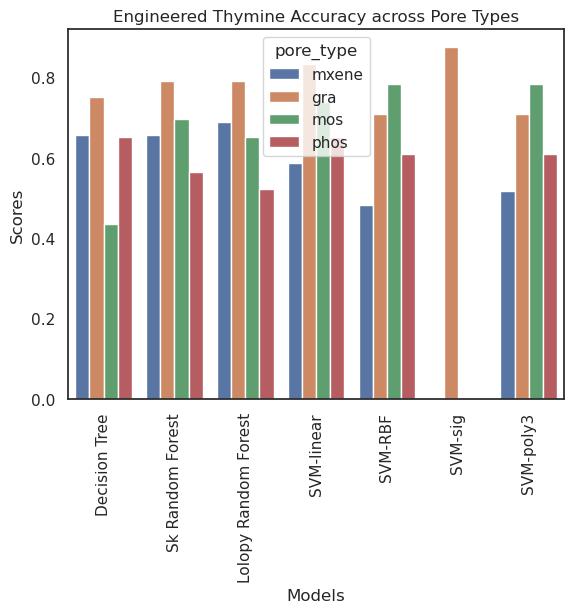

In [40]:
T_pos_e =all_data_df_e.index[all_data_df_e['Classes']=='T'].tolist()
T_df_e = all_data_df_e.iloc[T_pos_e,:]
# All models accuracy
sns.set(style='white')

# #create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='pore_type', data=T_df_e).set(title='Engineered Thymine Accuracy across Pore Types')
plt.xticks(rotation=90)

Je finis ce projet

# Adding Bandwith and Probability of Full Pass

In [41]:
phos_new =  pd.ExcelFile (r"/home/vazumah/AIML24787-Project/ML Final Project Data/Phos_band_data.xlsx") 

In [42]:
phos_new.sheet_names

['A', 'C', 'G', 'T']

In [43]:
for sheet in phos_new.sheet_names:
    my_vars[f'{sheet}_new'] = phos_new.parse(sheet)

In [44]:
X_new_df = np.concatenate((A_new, C_new,G_new,T_new), axis=0)

### Testing with both bandwidth and probability of full pass

In [45]:
Xphos_2 = np.concatenate((Xphos, X_new_df[:, 1:]), axis=1)
Xeng_phos_2 = np.concatenate((Xeng_phos, X_new_df[:, 1:]), axis=1)

   Eigenvalues  Feature Number
0     1.128482               1
1     0.184555               2
2     0.036760               4
3     0.024393               3


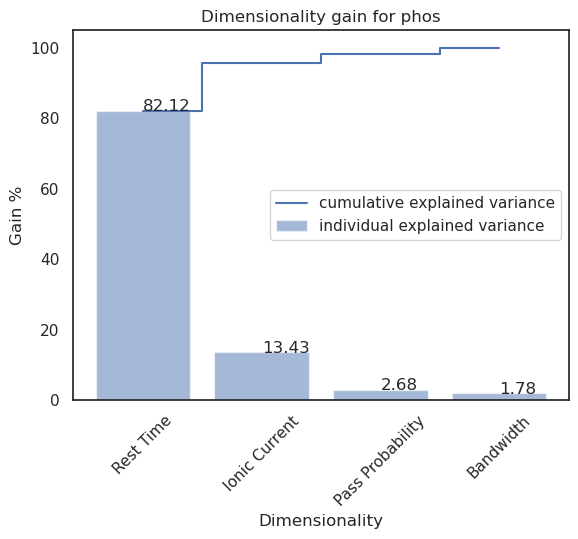

   Eigenvalues  Feature Number
0     1.438554               1
1     0.251006               2
2     0.123920               3
3     0.036585               5
4     0.024127               4


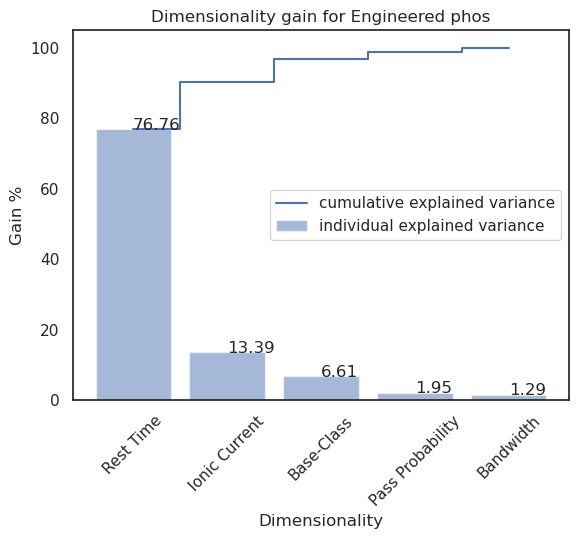

In [65]:
my_vars[f'var_weights_phos_2'],my_vars[f'sorted_eig_vecs_phos_2'] =  eval(Xphos_2, 'phos')
my_vars[f'var_weights_phos_2_e'],my_vars[f'sorted_eig_vecs_phos_2_e'] =  eval(Xeng_phos_2, 'phos', 1)

In [46]:

pore2= 'phos'
phos_2_df = training_and_plots(Xphos_2,yphos, name=pore2)
phos_2_df_e = training_and_plots(Xeng_phos_2, yphos, name=pore2)
# my_vars[f'{pore}_df_p'] = training_and_plots(my_vars[f'X{pore}'],my_vars[f'dna_{pore}'], mode='binary', name=pore2)

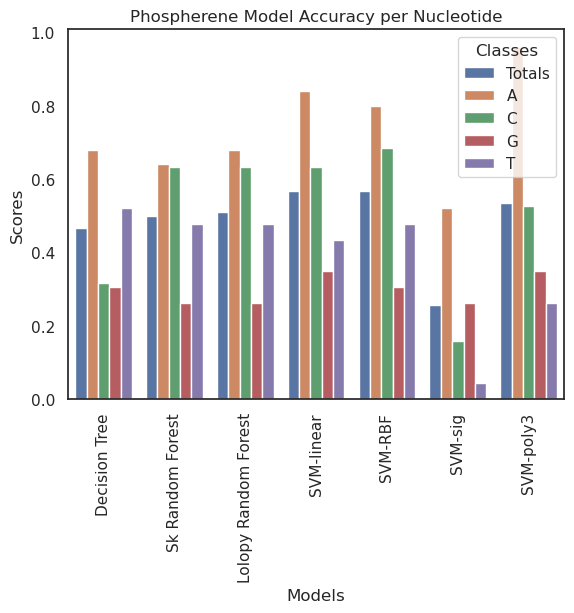

In [47]:

pore2= 'phos'
phos_2_df = training_and_plots(Xphos_2,yphos, name=pore2)
phos_2_df_e = training_and_plots(Xeng_phos_2, yphos, name=pore2)

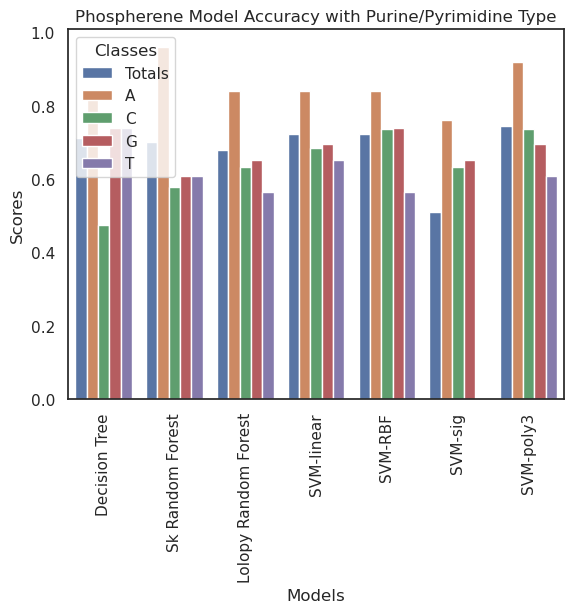

In [48]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_2_df_e).set(title='Phospherene Model Accuracy with Purine/Pyrimidine Type') 
#classifying only purines and pyrimidines
plt.xticks(rotation=90)
plt.show()

### Testing with only bandwidth

In [49]:
Xphos_b = np.concatenate((Xphos, X_new_df[:, 1].reshape(-1,1)), axis=1)
Xeng_phos_b = np.concatenate((Xeng_phos, X_new_df[:,1].reshape(-1,1)), axis=1)


phos_b_df = training_and_plots(Xphos_b,yphos, name=pore2)
phos_b_df_e = training_and_plots(Xeng_phos_b, yphos, name=pore2)
# my_vars[f'{pore}_df_p'] = training_and_plots(my_vars[f'X{pore}'],my_vars[f'dna_{pore}'], mode='binary', name=pore2)

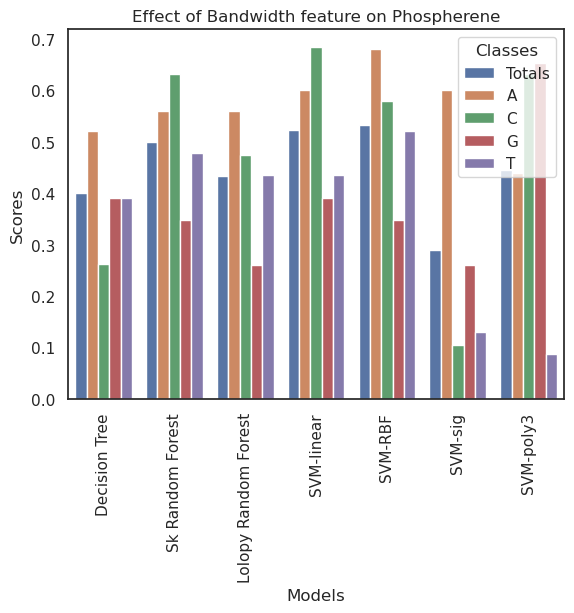

In [50]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_b_df).set(title='Effect of Bandwidth feature on Phospherene') 
plt.xticks(rotation=90)
plt.show()

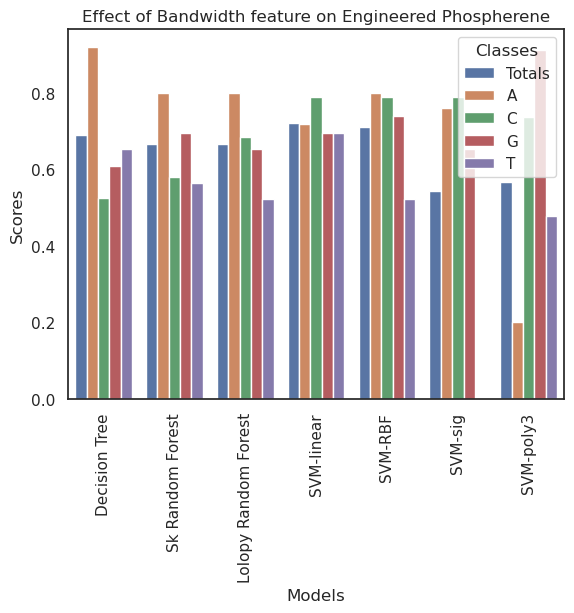

In [51]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_b_df_e).set(title='Effect of Bandwidth feature on Engineered Phospherene') 
#classifying only purines and pyrimidines
plt.xticks(rotation=90)
plt.show()

### Testing with only probability of full pass

In [52]:
Xphos_f = np.concatenate((Xphos, X_new_df[:, 2].reshape(-1,1)), axis=1)
Xeng_phos_f = np.concatenate((Xeng_phos, X_new_df[:,2].reshape(-1,1)), axis=1)


phos_f_df = training_and_plots(Xphos_f,yphos, name=pore2)
phos_f_df_e = training_and_plots(Xeng_phos_f, yphos, name=pore2)
# my_vars[f'{pore}_df_p'] = training_and_plots(my_vars[f'X{pore}'],my_vars[f'dna_{pore}'], mode='binary', name=pore2)

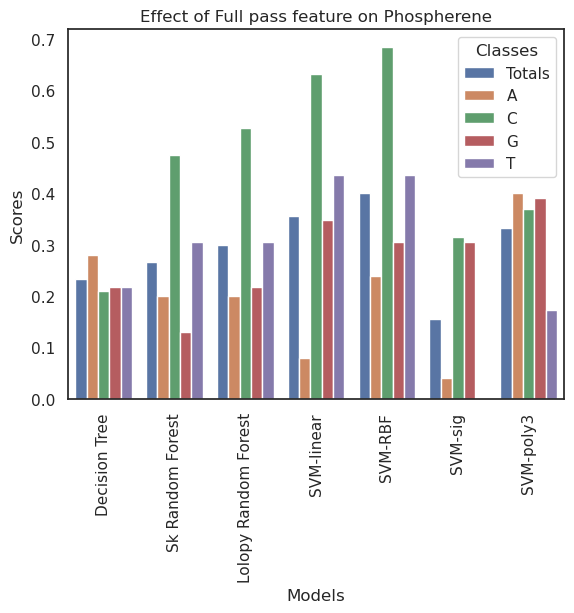

In [53]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_f_df).set(title='Effect of Full pass feature on Phospherene') 
plt.xticks(rotation=90)
plt.show()

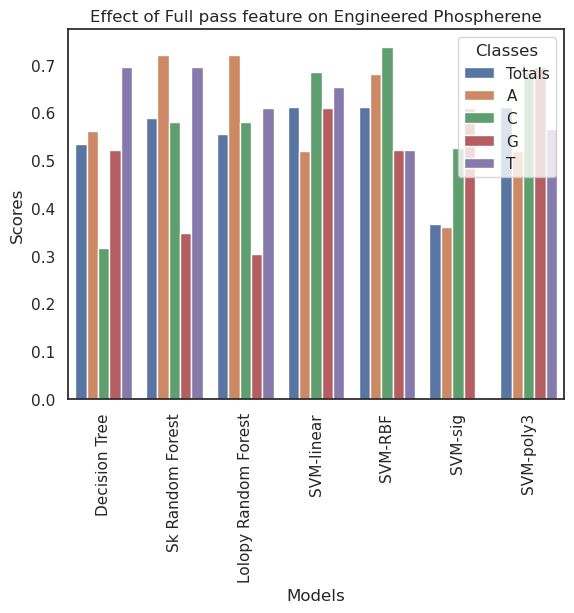

In [54]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_f_df_e).set(title='Effect of Full pass feature on Engineered Phospherene') 
#classifying only purines and pyrimidines
plt.xticks(rotation=90)
plt.show()

# Polynomial Features

In [55]:
def polysearch(X,y, degree= 3):
    groups = ['Degree', 'Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest',
              'SVM-linear', 'SVM-RBF', 'SVM-sig','SVM-poly3']
    out_mat = np.zeros([degree, len(groups)], dtype=float)
    degs = np.linspace(1, degree, degree)
    out_mat[:,0] = degs.ravel()
    for ii in range(degree):
        trans = PolynomialFeatures(degree=ii+1)
        data = trans.fit_transform(X)
        # data_eng = trans.fit_transform(Xeng_gra)
        totals, _, _ = trainers(data,y)
        out_mat[ii, 1:]= np.array(totals).ravel()
    
    out_df = pd.DataFrame(out_mat, columns=groups)
    out_df_m = out_df.melt('Degree', var_name='Models', value_name='Accuracy')
    return out_df_m

## polysearch on initial data

mxene


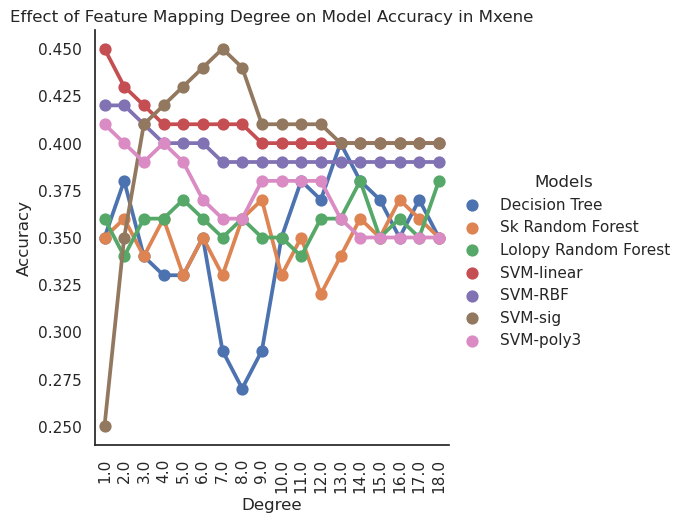

gra


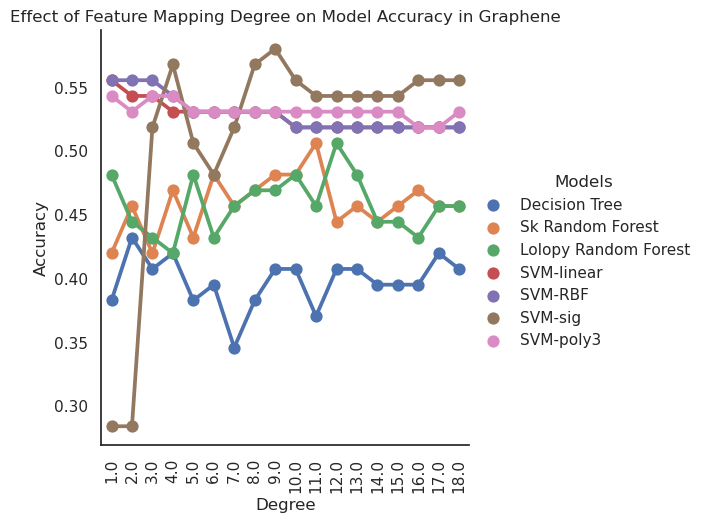

mos


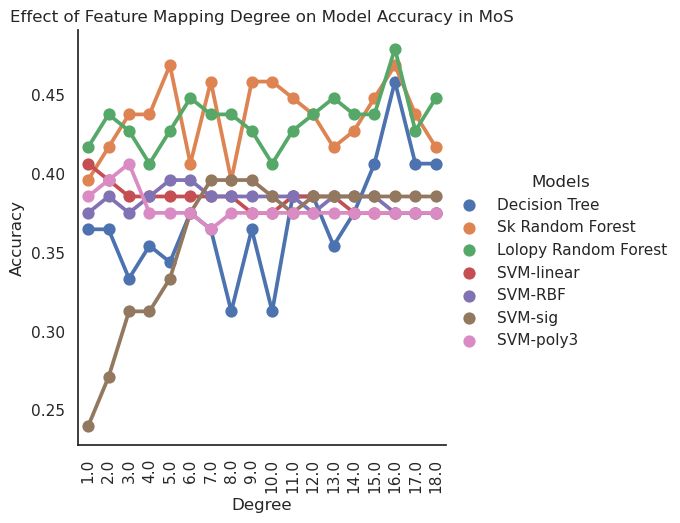

phos


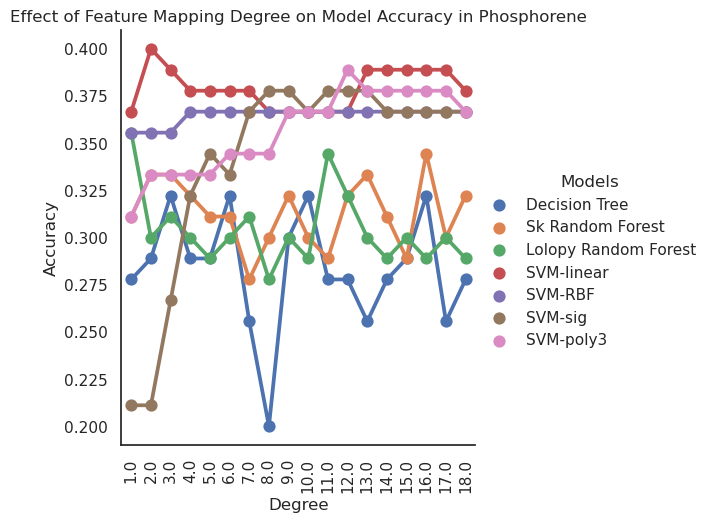

In [56]:
pores_2 = ['mxene', *pores]
pore_names = ['Mxene', 'Graphene', 'MoS', 'Phosphorene']
for ind, pore in enumerate(pores_2):
    print(pore)
    my_vars[f'Accuracy_df_{pore}'] = polysearch(my_vars[f'X{pore}'], my_vars[f'y{pore}'], degree=18)
    sns.catplot(x="Degree", y="Accuracy", hue='Models', data=my_vars[f'Accuracy_df_{pore}'], kind='point').set(title=f'Effect of Feature Mapping Degree on Model Accuracy in {pore_names[ind]}') 
    plt.xticks(rotation=90)
    plt.show()

## polysearch on engineered data

mxene


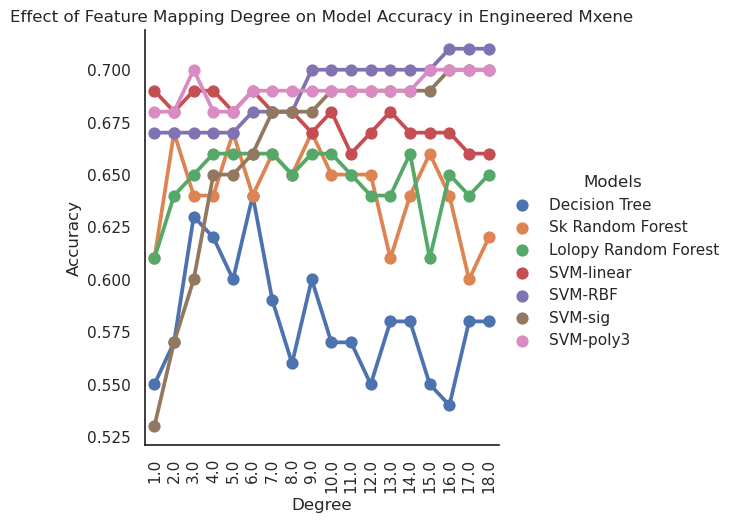

gra


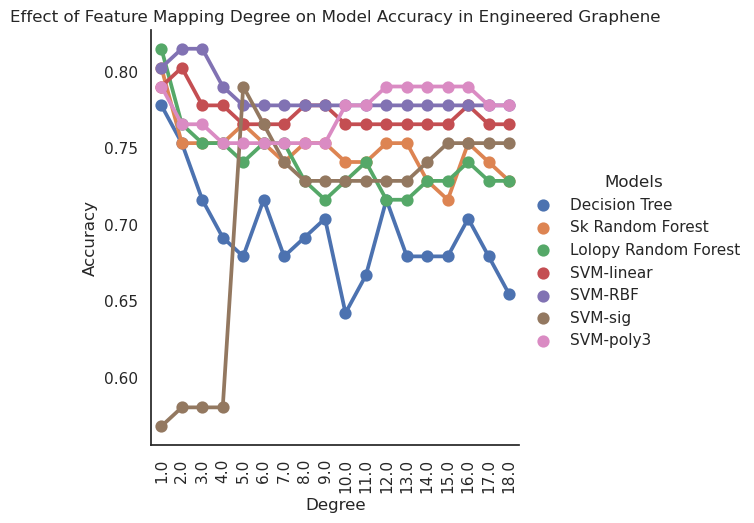

mos


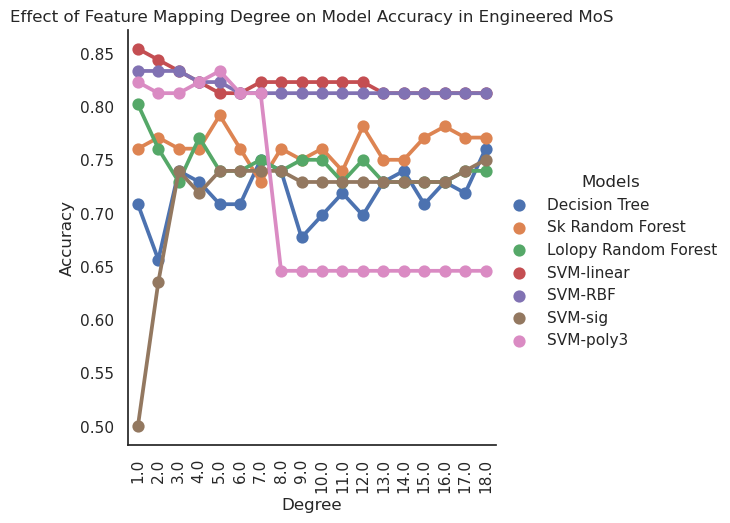

phos


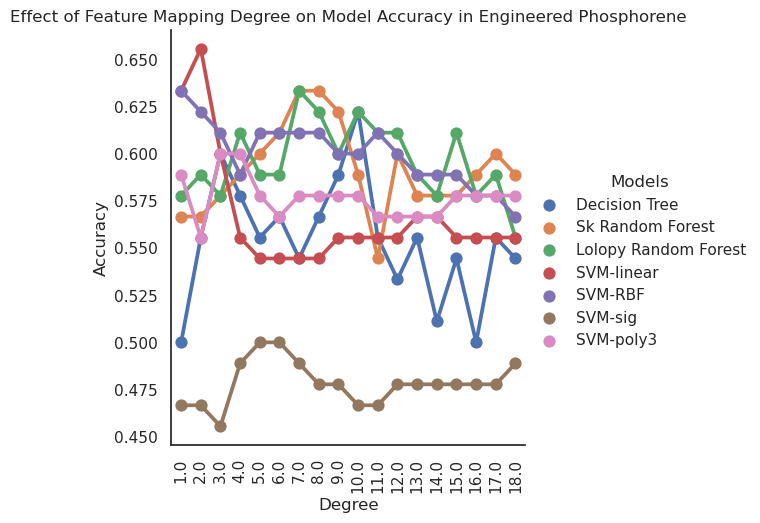

In [57]:
for ind, pore in enumerate(pores_2):
    print(pore)
    my_vars[f'Accuracy_df_{pore}_e'] = polysearch(my_vars[f'Xeng_{pore}'], my_vars[f'y{pore}'], degree=18)
    sns.catplot(x="Degree", y="Accuracy", hue='Models', data=my_vars[f'Accuracy_df_{pore}_e'], kind='point').set(title=f'Effect of Feature Mapping Degree on Model Accuracy in Engineered {pore_names[ind]}') 
    plt.xticks(rotation=90)
    plt.show()

# SVM kernel = poly analysis

In [58]:
def svm_poly_train(X,y, degree=3):
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size =  0.3, random_state=300)
    
    svm_model_p = svm.SVC(kernel='poly', degree=degree)
    svm_model_p= svm_model_p.fit(X_train, y_train)
    svm_model_p_res_pred = svm_model_p.predict(X_test)
    svm_model_p_score = accuracy_score(y_test, svm_model_p_res_pred)
    
    svm_model_l = svm.SVC(kernel='linear')
    svm_model_l= svm_model_l.fit(X_train, y_train)
    svm_model_l_res_pred = svm_model_l.predict(X_test)
    svm_model_l_score = accuracy_score(y_test, svm_model_l_res_pred)
    
    svm_model_r = svm.SVC()
    svm_model_r= svm_model_r.fit(X_train, y_train)
    svm_model_r_res_pred = svm_model_r.predict(X_test)
    svm_model_r_score = accuracy_score(y_test, svm_model_r_res_pred)
    
    scores = [svm_model_p_score, svm_model_l_score, svm_model_r_score]
    return scores

In [59]:
def svm_polysearch(X,y, degree=3):
    groups = ['Kernel', 'SVM-polyn', 'SVM-linear', 'SVM-rbf']
    out_mat = np.zeros([degree, len(groups)], dtype=float)
    degs = np.linspace(1, degree, degree)
    out_mat[:,0] = degs.ravel()
    
    for ii in range(degree):
         accs = svm_poly_train(X,y.ravel(), degree=ii+1)
         out_mat[ii, 1:] = accs
        
    out_df = pd.DataFrame(out_mat, columns=groups)
    out_df_m = out_df.melt('Kernel', var_name='Model', value_name='Accuracy')
    return out_df_m

mxene


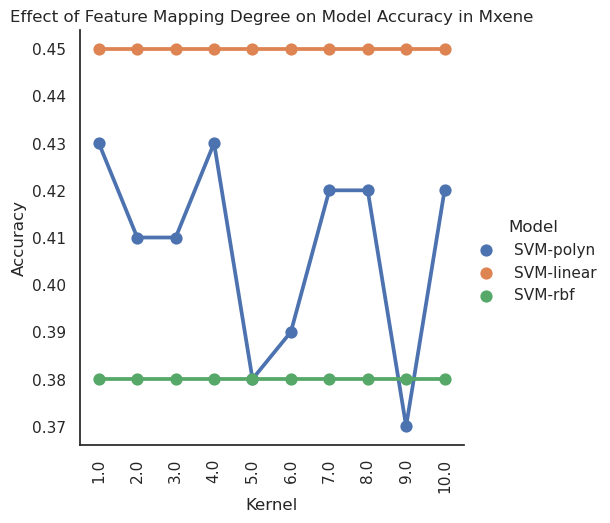

gra


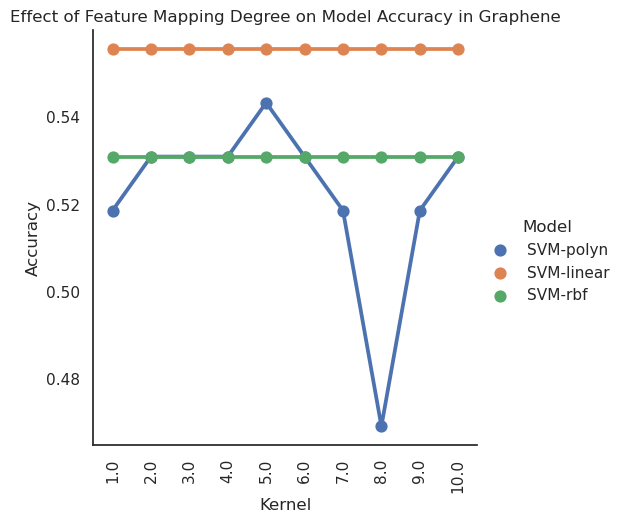

mos


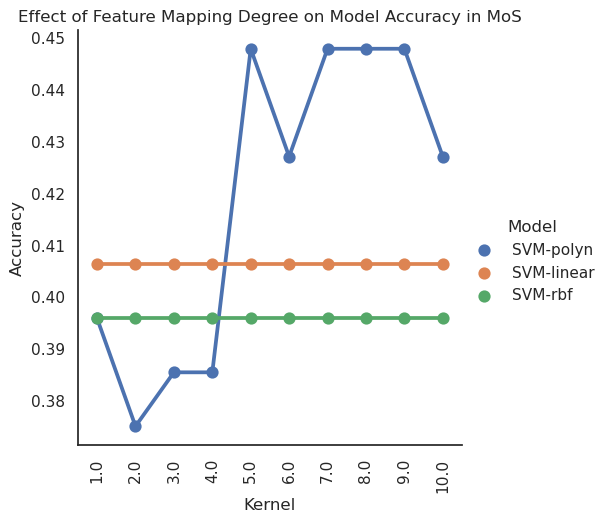

phos


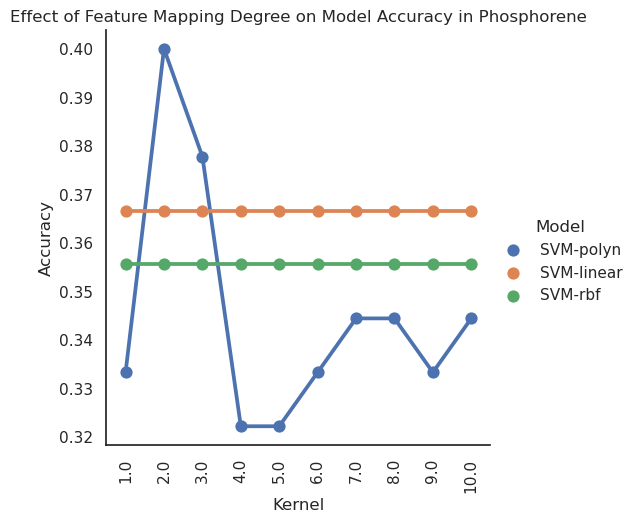

In [60]:
for ind, pore in enumerate(pores_2):
    print(pore)
    my_vars[f'kernelSearch_df_{pore}'] = svm_polysearch(my_vars[f'X{pore}'], my_vars[f'y{pore}'], degree=10)
    sns.catplot(x="Kernel", y="Accuracy", hue='Model', data=my_vars[f'kernelSearch_df_{pore}'], kind='point').set(title=f'Effect of Feature Mapping Degree on Model Accuracy in {pore_names[ind]}') 
    plt.xticks(rotation=90)
    plt.show()

mxene


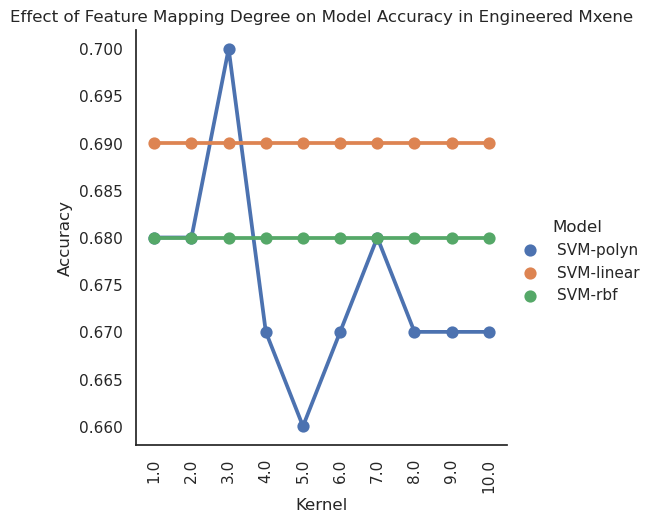

gra


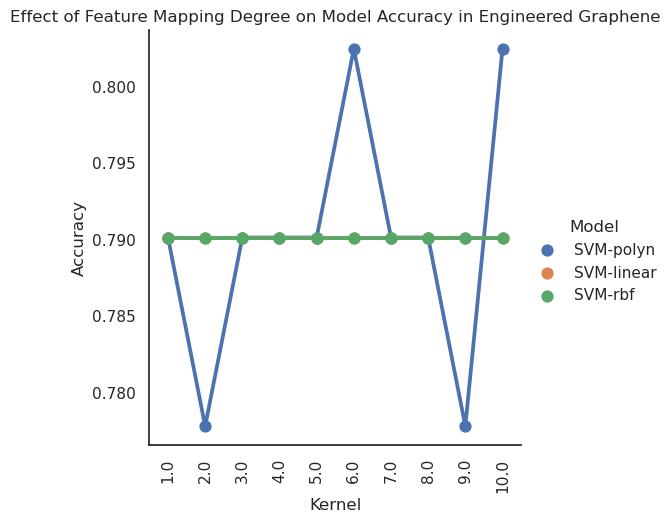

mos


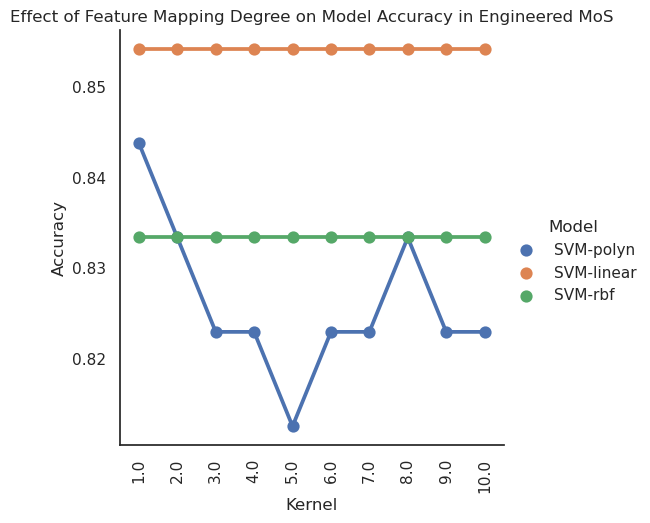

phos


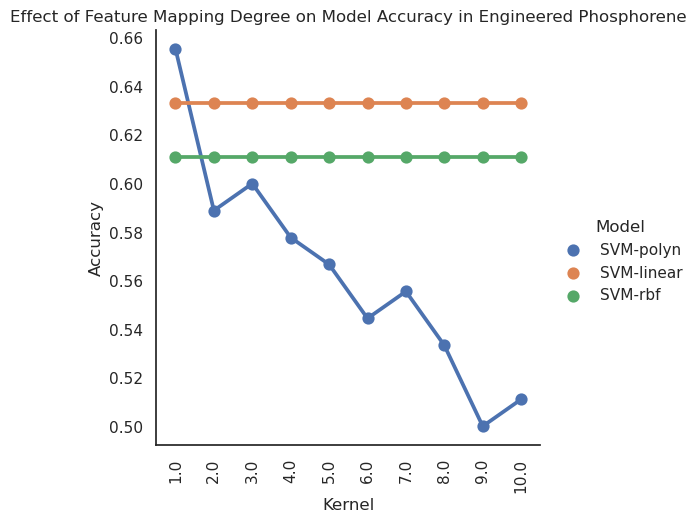

In [68]:
for ind, pore in enumerate(pores_2):
    print(pore)
    my_vars[f'kernelSearch_df_{pore}_e'] = svm_polysearch(my_vars[f'Xeng_{pore}'], my_vars[f'y{pore}'], degree=10)
    sns.catplot(x="Kernel", y="Accuracy", hue='Model', data=my_vars[f'kernelSearch_df_{pore}_e'], kind='point').set(title=f'Effect of Feature Mapping Degree on Model Accuracy in Engineered {pore_names[ind]}') 
    plt.xticks(rotation=90)
    plt.show()